<a href="https://colab.research.google.com/github/Vargol/StableDiffusionColabs/blob/main/AuraFlow/Auraflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install git+https://github.com/huggingface/diffusers.git mediapy

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-68jm8cm4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-68jm8cm4
  Resolved https://github.com/huggingface/diffusers.git to commit c646fbc1247e444c18da3db5c7ffb1438ca05394
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.2 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2519279 sha256=8dddf6974783d403af2c5cc2617852ce8ab9f230d3501948d60d6484f614d769
  Stored in directory: /tmp/pip-ephem-wheel-cache-cil8xzk8/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers


In [1]:
from diffusers import AuraFlowPipeline, AutoencoderKL
from diffusers.image_processor import VaeImageProcessor
import torch
import gc

model_id = 'Vargol/auraflow0.2-fp16-diffusers'

te_pipeline = AuraFlowPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    transformer=None,
    variant="fp16",
).to("cuda")

prompt = "A still image from a movie of a close up of a red haired woman standing in a lush green jungle"
negative_prompt = "cgi, computer graphics, painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured"

with torch.no_grad():
  prompt_embeds,prompt_attention_mask, negative_embeds, negative_prompt_attention_mask = te_pipeline.encode_prompt(prompt, negative_prompt=negative_prompt)

del te_pipeline
gc.collect()
torch.cuda.empty_cache()





Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
import mediapy
import random
import sys

pipeline = AuraFlowPipeline.from_pretrained (
      model_id,
      torch_dtype=torch.float16,
      text_encoder=None,
      tokenizer=None,
      vae=None,
      variant="fp16",
).to("cuda")


latents = []

for i in range(5):

  seed = random.randint(0, sys.maxsize)
  generator =  torch.Generator("cuda").manual_seed(seed);

  latent = pipeline(
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_embeds,
        prompt_attention_mask=prompt_attention_mask,
        negative_prompt_attention_mask=negative_prompt_attention_mask,
        height=1024,
        width=1024,
        num_inference_steps=50,
        generator=generator,
        guidance_scale=3.5,
        output_type='latent',
    ).images

  latents.append(latent)

pipeline = None
gc.collect()
torch.cuda.empty_cache()



Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


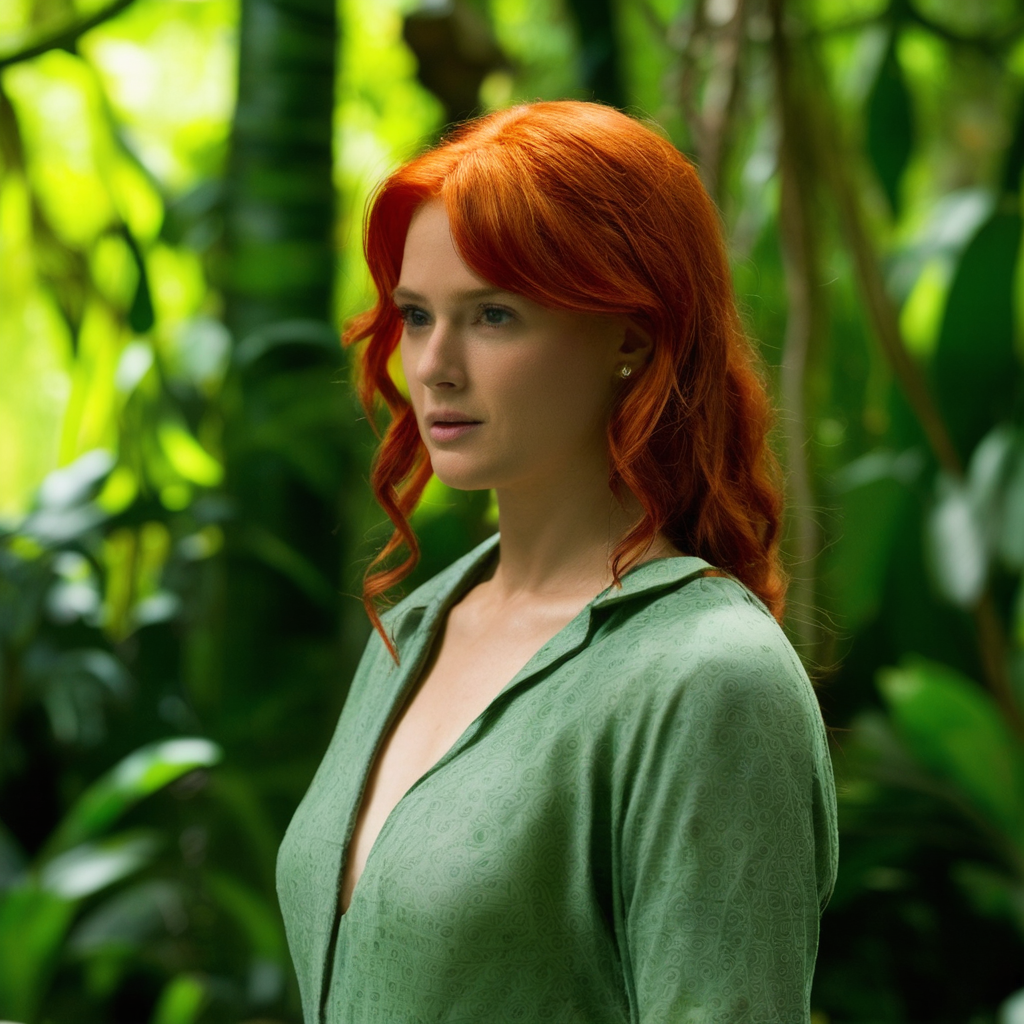


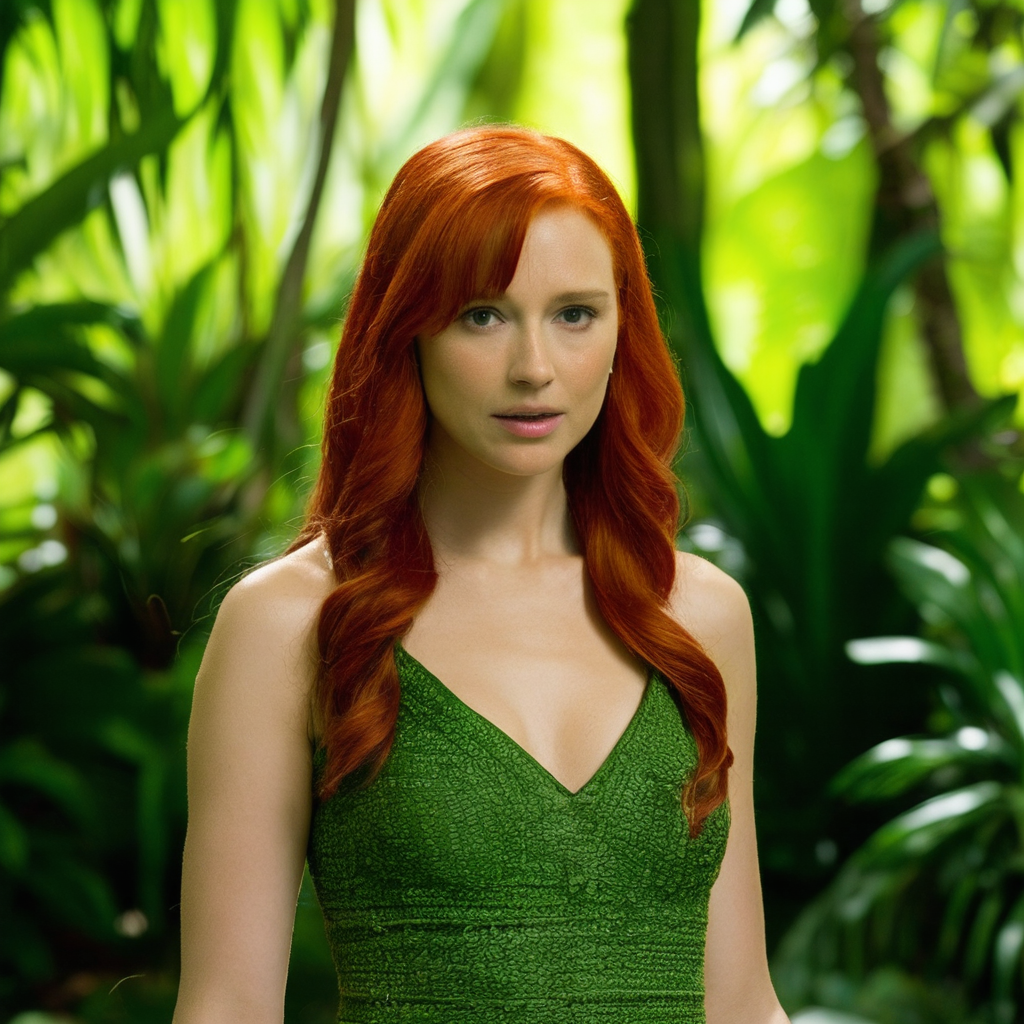


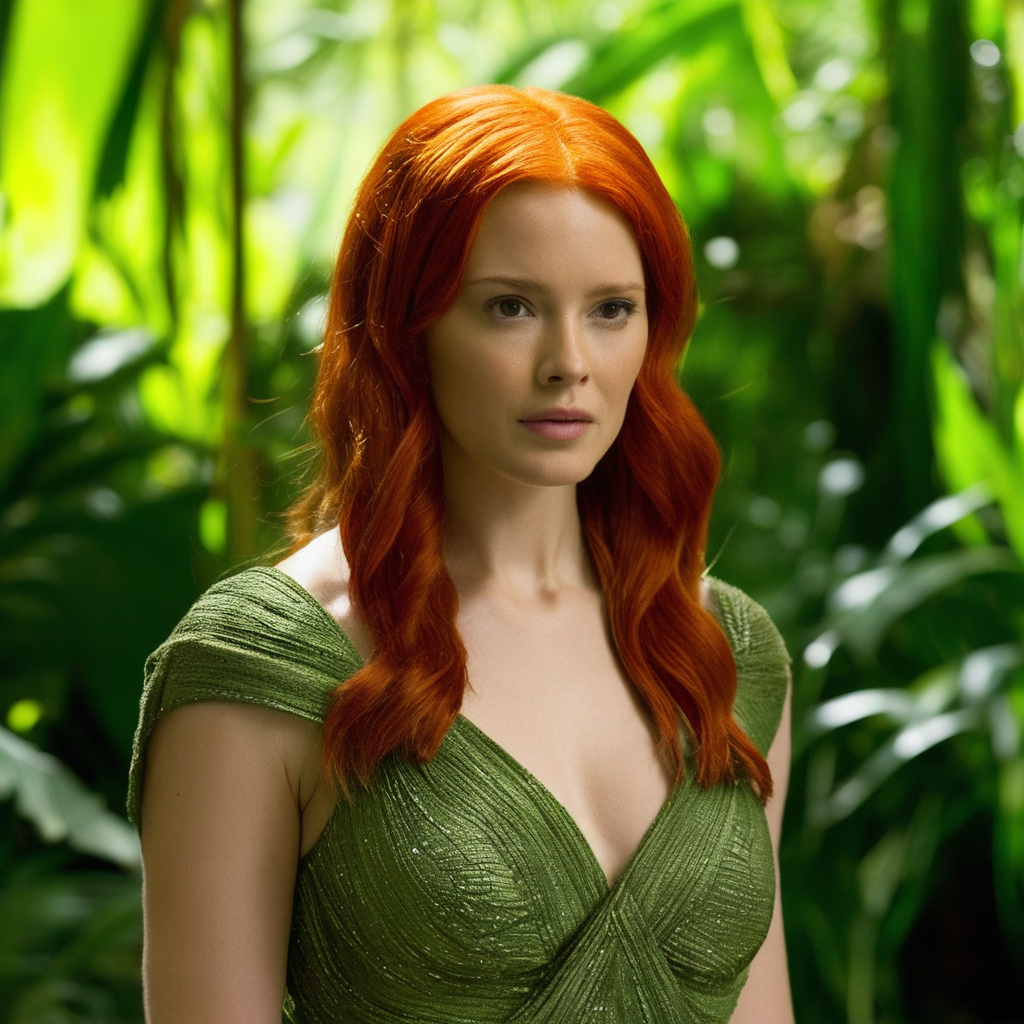


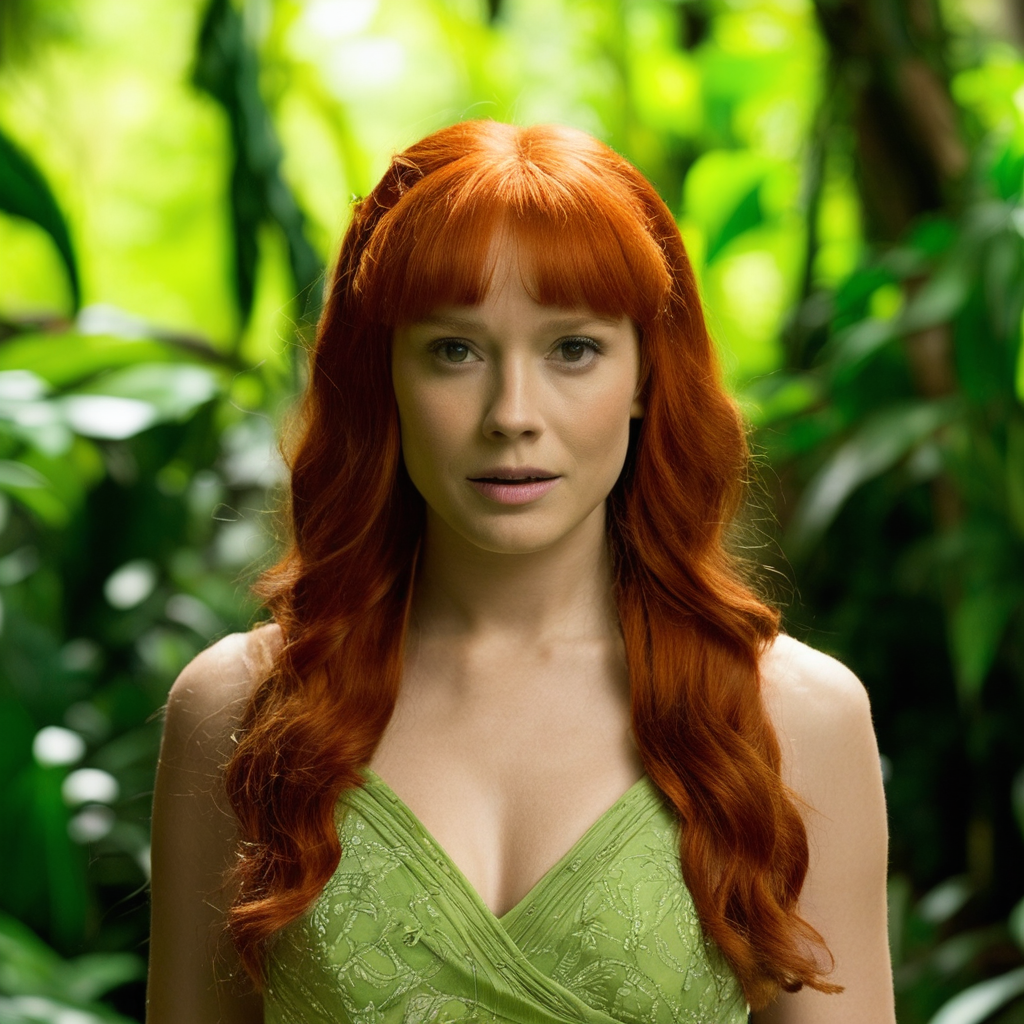


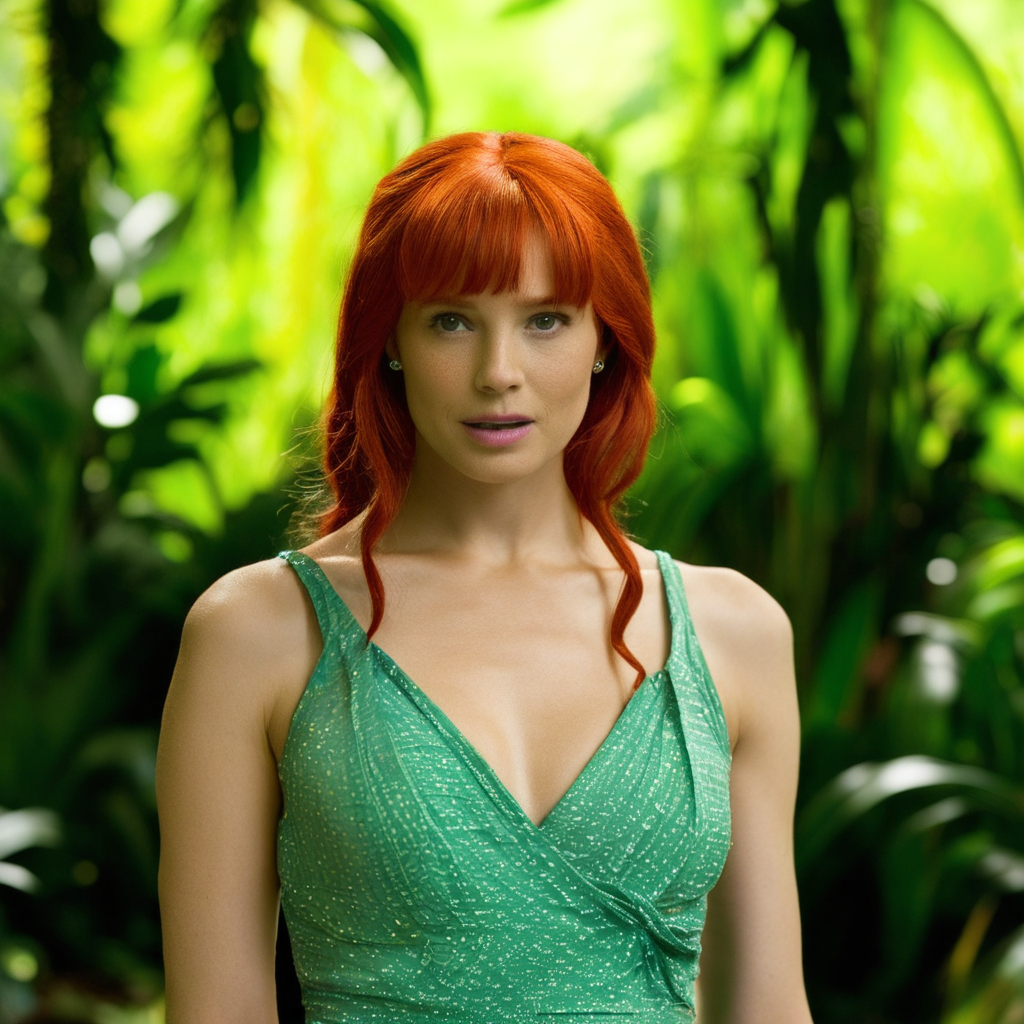

In [9]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16,
                                    force_upcast=False).to("cuda")

for latent in latents:

  image = vae.decode(latent / vae.config.scaling_factor, return_dict=False)
  with torch.no_grad():
      vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
      image_processor = VaeImageProcessor(vae_scale_factor=vae_scale_factor)
      image = image_processor.postprocess(image[0], output_type='pil', do_denormalize=[True])[0]

  mediapy.show_images([image])

vae = None
gc.collect()
torch.cuda.empty_cache()